In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score



Read the data, assuming that the file ```npf_train.csv``` (not provided) is placed in the same directory as this notebook.


In [2]:
npf = pd.read_csv("npf_train.csv")
npf.head()

,id,date,class4,partlybad,CO2168.mean,CO2168.std,CO2336.mean,CO2336.std,CO242.mean,CO242.std,...,T672.mean,T672.std,T84.mean,T84.std,UV_A.mean,UV_A.std,UV_B.mean,UV_B.std,CS.mean,CS.std
0,1,2000-01-17,Ib,False,368.771711,0.310309,368.665658,0.305127,369.371184,0.333606,...,-1.476016,0.250952,-0.899393,0.271648,2.492491,1.310880,0.031587,0.018122,0.000243,0.000035
1,2,2000-02-28,nonevent,False,378.197295,1.001493,378.083089,1.025472,378.671311,1.017208,...,1.479493,0.313460,2.033191,0.271090,0.295937,0.177836,0.005140,0.003552,0.003658,0.000940
2,3,2000-03-24,Ib,False,373.043158,0.749865,372.930066,0.728411,373.569735,0.835240,...,-0.270844,2.037111,0.780422,2.334741,14.434789,8.627312,0.353743,0.272472,0.000591,0.000191
3,4,2000-03-30,II,False,375.643019,0.558629,375.549430,0.540964,376.045849,0.580730,...,5.622308,2.509758,6.533544,2.695277,16.077513,9.984686,0.568242,0.451830,0.002493,0.000466
4,5,2000-04-04,nonevent,False,377.661030,0.408421,377.609576,0.423963,378.117134,0.417243,...,1.140121,1.438071,2.133774,1.614122,9.710422,7.054069,0.339135,0.291457,0.004715,0.000679


Preprocess the data. Set column ```date``` as index, and remove column ```partlybad``` since it is always false. Create the variable ```class2``` which is ```event``` if the observation belongs to any class of NPF events and ```nonevent``` otherwise.

In [3]:
npf = npf.set_index("date")
npf = npf.drop("id", axis=1)
npf = npf.drop("partlybad", axis=1)

class2 = np.array(["nonevent", "event"])
class2_numeric = np.array([0, 1])
npf["class2"] = class2[(npf["class4"]!="nonevent").astype(int)]
npf["class2_numeric"] = class2_numeric[(npf["class4"]!="nonevent").astype(int)]

npf.head()


,class4,CO2168.mean,CO2168.std,CO2336.mean,CO2336.std,CO242.mean,CO242.std,CO2504.mean,CO2504.std,Glob.mean,...,T84.mean,T84.std,UV_A.mean,UV_A.std,UV_B.mean,UV_B.std,CS.mean,CS.std,class2,class2_numeric
date,,,,,,,,,,,,,,,,,,,,,
2000-01-17,Ib,368.771711,0.310309,368.665658,0.305127,369.371184,0.333606,368.616053,0.302364,41.650106,...,-0.899393,0.271648,2.492491,1.310880,0.031587,0.018122,0.000243,0.000035,event,1
2000-02-28,nonevent,378.197295,1.001493,378.083089,1.025472,378.671311,1.017208,378.029508,1.022258,3.478842,...,2.033191,0.271090,0.295937,0.177836,0.005140,0.003552,0.003658,0.000940,nonevent,0
2000-03-24,Ib,373.043158,0.749865,372.930066,0.728411,373.569735,0.835240,372.869868,0.692828,297.954063,...,0.780422,2.334741,14.434789,8.627312,0.353743,0.272472,0.000591,0.000191,event,1
2000-03-30,II,375.643019,0.558629,375.549430,0.540964,376.045849,0.580730,375.506013,0.529970,324.318386,...,6.533544,2.695277,16.077513,9.984686,0.568242,0.451830,0.002493,0.000466,event,1
2000-04-04,nonevent,377.661030,0.408421,377.609576,0.423963,378.117134,0.417243,377.582242,0.424460,167.479964,...,2.133774,1.614122,9.710422,7.054069,0.339135,0.291457,0.004715,0.000679,nonevent,0


Find the most frequent type of NPF event. Use this in the multi-class prediction to predict the most frequent event class for all days predicted to be event days. If there are more than one event types with the highest frequency, simply pick one of them.


In [4]:
npf_events = npf[(npf["class4"]!="nonevent")]["class4"]
most_frequent_event = npf_events.mode()[0]


Plot the correlation matrix.


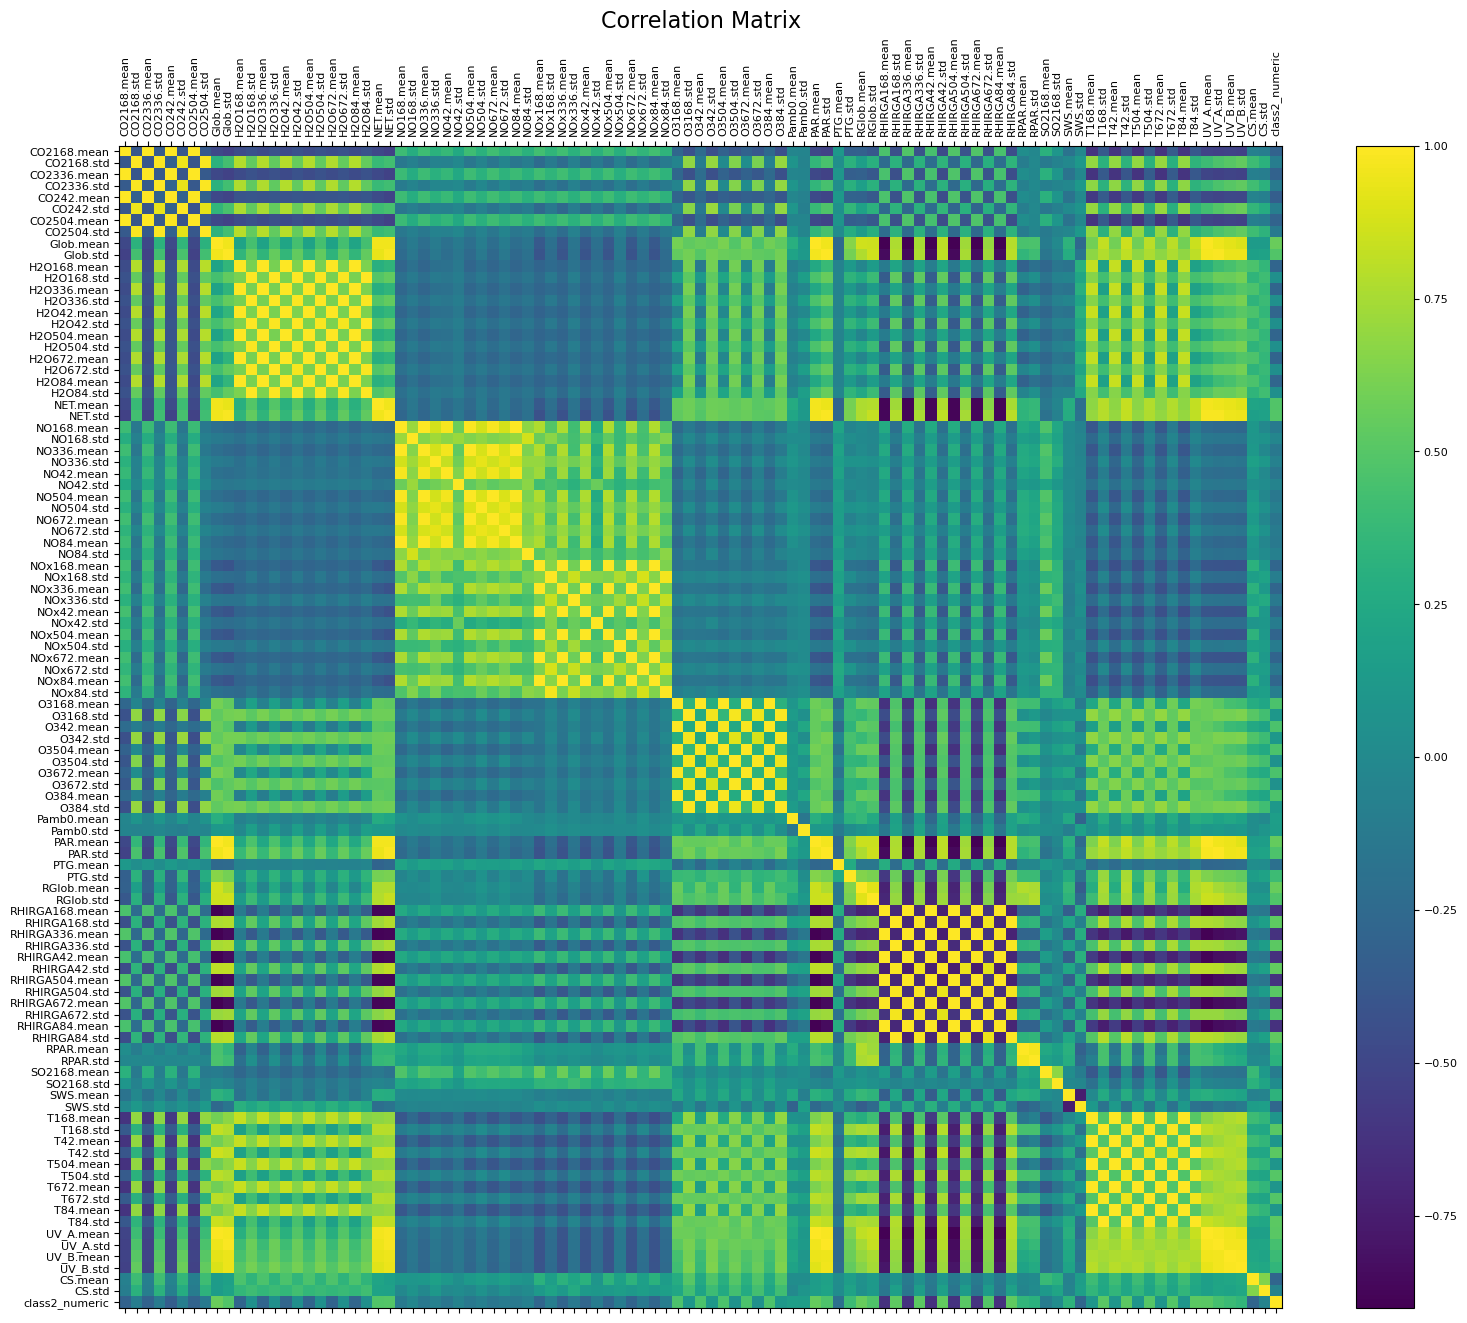

In [5]:
f = plt.figure(figsize=(19, 15))
plt.matshow(npf.corr(), fignum=f.number)
plt.xticks(range(npf.select_dtypes(['number']).shape[1]), npf.select_dtypes(['number']).columns, fontsize=8, rotation=90)
plt.yticks(range(npf.select_dtypes(['number']).shape[1]), npf.select_dtypes(['number']).columns, fontsize=8)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=8)
plt.title('Correlation Matrix', fontsize=16);


More preprocessing. The correlation matrix shows that similar measurements from different mast heights are highly correlated, and their correlation with ```class2``` is similar to each other, so drop some of the measurements from different heights. Split into features and target. Scale the variables that are used as features.

In [6]:
X = npf.drop(["class4", "class2", "class2_numeric",
              "CO2336.mean", "CO2336.std", "CO242.mean", "CO242.std", "CO2504.mean", "CO2504.std",
              "H2O336.mean","H2O336.std","H2O42.mean","H2O42.std","H2O504.mean","H2O504.std","H2O672.mean","H2O672.std","H2O84.mean","H2O84.std",
              "NO336.mean","NO336.std","NO42.mean","NO42.std","NO504.mean","NO504.std","NO672.mean","NO672.std","NO84.mean","NO84.std",
              "NOx336.mean","NOx336.std","NOx42.mean","NOx42.std","NOx504.mean","NOx504.std","NOx672.mean","NOx672.std","NOx84.mean","NOx84.std",
              "O342.mean","O342.std","O3504.mean","O3504.std","O3672.mean","O3672.std","O384.mean","O384.std",
              "RHIRGA336.mean","RHIRGA336.std","RHIRGA42.mean","RHIRGA42.std","RHIRGA504.mean","RHIRGA504.std","RHIRGA672.mean","RHIRGA672.std","RHIRGA84.mean","RHIRGA84.std",
              "T42.mean","T42.std","T504.mean","T504.std","T672.mean","T672.std","T84.mean","T84.std"], axis=1)
y = npf["class2"]

scaler2 = StandardScaler().fit(X)
X_scaled = scaler2.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=scaler2.feature_names_in_)

Train the model.

Train logistic regression models with different parameters. Use cross-validation to estimate which model has the best performance. Since a separate test data set is provided for the final evaluation of accuracy by the course staff, use the full training data set for cross-validation and training.

Since there is a large number of variables in the data, experiment with regularisation to control the complexity of the model. Try to find a model that has a high accuracy and coefficient 0 for a large amount features. The aim is to find a model that is not too complex, to avoid overfitting.


In [7]:
model1 = LogisticRegression(penalty="none", max_iter=2000)
cv_scores1 = cross_val_score(model1, X_scaled, y, cv=10)
cv_score_mean1 = cv_scores1.mean()
model1.fit(X_scaled, y)
n_zeros1 = (model1.coef_==0).sum()
print("Model 1 results:")
print(f"- Cross validation score (mean): {cv_score_mean1}")
print(f"- Number of features with 0 coefficient: {n_zeros1}")

model2 = LogisticRegression(penalty="l1", solver="saga", max_iter=2000)
cv_scores2 = cross_val_score(model2, X_scaled, y, cv=10)
cv_score_mean2 = cv_scores2.mean()
model2.fit(X_scaled, y)
n_zeros2 = (model2.coef_==0).sum()
print("Model 2 results:")
print(f"- Cross validation score (mean): {cv_score_mean2}")
print(f"- Number of features with 0 coefficient: {n_zeros2}")

model3 = LogisticRegression(penalty="l2", solver="saga", max_iter=2000)
cv_scores3 = cross_val_score(model3, X_scaled, y, cv=10)
cv_score_mean3 = cv_scores3.mean()
model3.fit(X_scaled, y)
n_zeros3 = (model3.coef_==0).sum()
print("Model 3 results:")
print(f"- Cross validation score (mean): {cv_score_mean3}")
print(f"- Number of features with 0 coefficient: {n_zeros3}")

model4 = LogisticRegression(penalty="elasticnet", l1_ratio=0.5, solver="saga", max_iter=2000)
cv_scores4 = cross_val_score(model4, X_scaled, y, cv=10)
cv_score_mean4 = cv_scores4.mean()
model4.fit(X_scaled, y)
n_zeros4 = (model4.coef_==0).sum()
print("Model 4 results:")
print(f"- Cross validation score (mean): {cv_score_mean4}")
print(f"- Number of features with 0 coefficient: {n_zeros4}")

Model 1 results:
- Cross validation score (mean): 0.8621646623496761
- Number of features with 0 coefficient: 0
Model 2 results:
- Cross validation score (mean): 0.8925531914893616
- Number of features with 0 coefficient: 15
Model 3 results:
- Cross validation score (mean): 0.8796484736355227
- Number of features with 0 coefficient: 0
Model 4 results:
- Cross validation score (mean): 0.8882978723404256
- Number of features with 0 coefficient: 9


Predict classes for the test data, using a model resulted in a high cross validation score. 

Preprocess the data similarly as the training data. Use the trained model to predict ```class2```(nonevent or event). Using a simple approach, predict ```class4``` (nonevent or one of the three event classes) by assigning the most frequent event type to all predicted events and keeping the predicted nonevents as nonevents. Output the predictions to a ```.csv``` file.


In [8]:
model = model2

test_data = pd.read_csv("npf_test_hidden.csv")
test_data = test_data.set_index("date")
test_data = test_data.drop("id", axis=1)
test_data = test_data.drop("partlybad", axis=1)
test_data = test_data.drop(["class4",
              "CO2336.mean", "CO2336.std", "CO242.mean", "CO242.std", "CO2504.mean", "CO2504.std",
              "H2O336.mean","H2O336.std","H2O42.mean","H2O42.std","H2O504.mean","H2O504.std","H2O672.mean","H2O672.std","H2O84.mean","H2O84.std",
              "NO336.mean","NO336.std","NO42.mean","NO42.std","NO504.mean","NO504.std","NO672.mean","NO672.std","NO84.mean","NO84.std",
              "NOx336.mean","NOx336.std","NOx42.mean","NOx42.std","NOx504.mean","NOx504.std","NOx672.mean","NOx672.std","NOx84.mean","NOx84.std",
              "O342.mean","O342.std","O3504.mean","O3504.std","O3672.mean","O3672.std","O384.mean","O384.std",
              "RHIRGA336.mean","RHIRGA336.std","RHIRGA42.mean","RHIRGA42.std","RHIRGA504.mean","RHIRGA504.std","RHIRGA672.mean","RHIRGA672.std","RHIRGA84.mean","RHIRGA84.std",
              "T42.mean","T42.std","T504.mean","T504.std","T672.mean","T672.std","T84.mean","T84.std"], axis=1)

scaler2 = StandardScaler().fit(test_data)
test_scaled = scaler2.transform(test_data)
test_scaled = pd.DataFrame(test_scaled, columns=scaler2.feature_names_in_)

p_hat = model.predict_proba(test_scaled)
p_hat = p_hat[:,0]

def get_event_class2(p):
    if p >= 0.5:
        return "event"
    else:
        return "nonevent"
    
def get_event_class4(p):
    if p>= 0.5:
        return most_frequent_event
    else:
        return "nonevent"

class2_pred = np.array([get_event_class2(p) for p in p_hat])

class4_pred = np.array([get_event_class4(p) for p in p_hat])

predictions = pd.DataFrame(data={"class4": class4_pred, "p": p_hat})

predictions.to_csv("answers.csv", index=False, float_format="%.15f")
